# Create dataset from yolo's dataset

In [ ]:
!unzip "/content/egg detection label.v1i.yolov8.zip" -d "/content/egg-detection-label-yolov8"

In [3]:
import os
import cv2

dataset_path = "/content/egg-detection-label-yolov8"
image_dir = "/content/egg-detection-label-yolov8/train/images"
labels_dir = "/content/egg-detection-label-yolov8/train/labels"
output_dir = "/content/egg-cropped"

os.makedirs(output_dir, exist_ok=True)

for label_file in os.listdir(labels_dir):
  if not label_file.endswith(".txt"):
    continue

  image_name = label_file.replace(".txt", ".jpg")
  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    continue

  img = cv2.imread(image_path)
  h, w, _ = img.shape

  with open(os.path.join(labels_dir, label_file), "r") as f:
    for i, line in enumerate(f):
      class_id, x_center, y_center, width, height = map(float, line.strip().split())

      x_center *= w
      y_center *= h
      width *= w
      height *= h

      x1 = int(x_center - width / 2)
      y1 = int(y_center - height / 2)
      x2 = int(x_center + width / 2)
      y2 = int(y_center + height / 2)

      crop = img[y1:y2, x1:x2]

      if crop.size == 0:
        continue

      # create folder
      class_folder = os.path.join(output_dir, f"class{int(class_id)}")
      os.makedirs(class_folder, exist_ok=True)

      # save img
      output_path = os.path.join(class_folder, f"{image_name[:-4]}_{i}.jpg")
      cv2.imwrite(output_path, crop)

In [4]:
!mv "/content/egg-cropped/class0" "/content/egg-cropped/Damaged"
!mv "/content/egg-cropped/class1" "/content/egg-cropped/Not Damaged"

In [5]:
dataset_dir = '/content/egg-cropped'

classes = os.listdir(dataset_dir)
print(f"classes: {classes}")

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} images")

classes: ['Damaged', 'Not Damaged']
Damaged: 728 images
Not Damaged: 177 images


# 2 Stages model

## classification model

In [6]:
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = "/content/egg-cropped"
output_dir = "/content/egg-split-cropped"

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

for d in [train_dir, val_dir, test_dir]:
  os.makedirs(d, exist_ok=True)

val_size = 0.15
test_size = 0.15

for class_name in os.listdir(dataset_dir):
  class_path = os.path.join(dataset_dir, class_name)
  if not os.path.isdir(class_path):
    continue

  images = os.listdir(class_path)
  images = [img for img in images if img.endswith(('.jpg'))]

  train_imgs, temp_imgs = train_test_split(images, test_size=(val_size + test_size), random_state=42)
  val_imgs, test_imgs = train_test_split(temp_imgs,test_size=test_size / (val_size + test_size), random_state=42)

  # copy files
  for split, split_imgs in zip(
      [train_dir, val_dir, test_dir],
      [train_imgs, val_imgs, test_imgs]
  ):
    split_class_dir = os.path.join(split, class_name)
    os.makedirs(split_class_dir, exist_ok=True)
    for img_name in split_imgs:
      shutil.copy(os.path.join(class_path, img_name), os.path.join(split_class_dir, img_name))



In [ ]:
!unzip '/content/egg-split-cropped-new.zip' -d '/content/egg-split-cropped-new'

In [7]:
import tensorflow as tf

data_dir = '/content/egg-split-cropped'
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "val"),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "test"),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# normalizing and caching
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(ds, training=False):
    if training:
        ds = ds.shuffle(1000)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)



Found 632 files belonging to 2 classes.
Found 136 files belonging to 2 classes.
Found 137 files belonging to 2 classes.


In [9]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # freeze base

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
for c in os.listdir('/content/egg-split-cropped-new/egg-split-cropped/train'):
    print(c, len(os.listdir(os.path.join('/content/egg-split-cropped-new/egg-split-cropped/train', c))))


Damaged 491
Not Damaged 110


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
  )

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7271 - loss: 0.6020 - val_accuracy: 0.8015 - val_loss: 0.4526
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.7965 - loss: 0.4776 - val_accuracy: 0.8015 - val_loss: 0.4266
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.8092 - loss: 0.4283 - val_accuracy: 0.8088 - val_loss: 0.4076
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.7994 - loss: 0.4104 - val_accuracy: 0.8235 - val_loss: 0.3937
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.8212 - loss: 0.3966 - val_accuracy: 0.8235 - val_loss: 0.3874
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8368 - loss: 0.3807 - val_accuracy: 0.8235 - val_loss: 0.3730
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8352 - loss: 0.3658 - val_accuracy: 0.8309 - val_loss: 0.3593
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.8210 - loss: 0.3564 - val_accuracy: 0.83

In [ ]:
!zip -r "/content/egg-split-cropped.zip" "/content/egg-split-cropped"

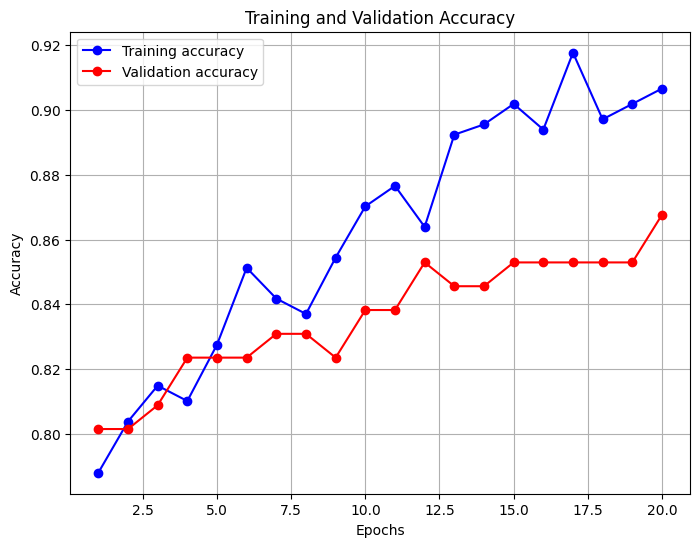

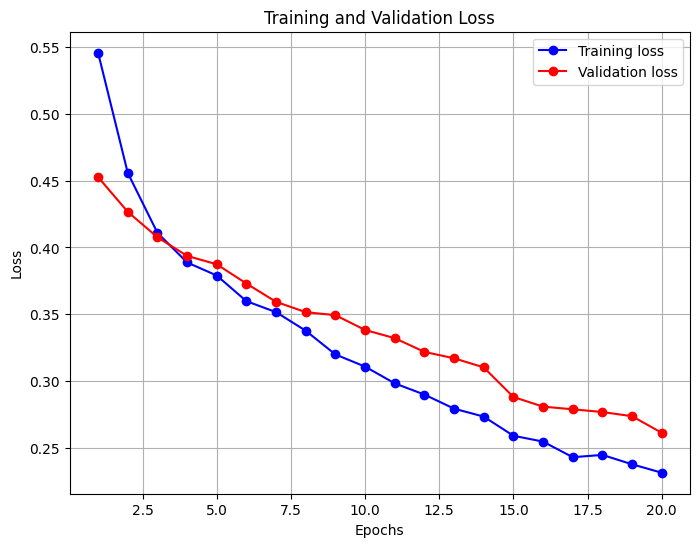

In [11]:
import matplotlib.pyplot as plt

# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8523 - loss: 0.3379


[0.3004761338233948, 0.8759124279022217]

In [ ]:
## Test object detection model